In [1]:
#Imports
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, \
RidgeCV, ElasticNet, ElasticNetCV

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler,\
                                  PolynomialFeatures

from sklearn.compose import ColumnTransformer

from sklearn.metrics import r2_score, mean_squared_error

### Problem statement

A developer has contracted me to determine which building decisions are the most impactful to the value of a property.  I will examine the Ames housing data to identify factors of development that should be kept in mind as the developer seeks to effectively allocate capital and planning recourses.

data: http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

### Load the data

[reset pandas display options](https://stackoverflow.com/questions/26246864/restoring-the-default-display-context-in-pandas)

In [2]:
houses = pd.read_csv('../datasets/train.csv')
houses_test = pd.read_csv('../datasets/test.csv')
pd.reset_option('^display.', silent=True)

Column rename source: Devin Fay

In [3]:
houses.columns = [col.lower().replace(" ", '_').replace("/", '_')  for col in \
                        houses.columns]
houses_test.columns = [col.lower().replace(" ", '_').replace("/", '_')  \
                       for col in houses_test.columns]

In [4]:
houses.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod_add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
       'g

### Explore the data

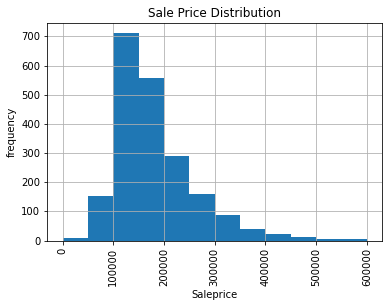

In [5]:
houses['saleprice'].hist(bins = np.arange(0,650_000,50_000)).set\
(title = "Sale Price Distribution", xlabel = 'Saleprice', \
 ylabel = 'frequency',\
 xticks = np.arange(0,650_000,100_000)
)
plt.xticks(rotation='vertical')
plt.savefig('../plots/saleprice_hist')

Above we see the distribution of saleprice.  It has a significant right skew, which is to be expected for an asset with potentially unbounded value.  

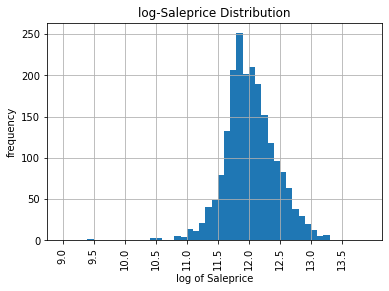

In [6]:
np.log(houses['saleprice']).hist(bins = np.arange(9,14,.1)).set\
(title = "log-Saleprice Distribution", xlabel = 'log of Saleprice', \
 ylabel = 'frequency',\
 xticks = np.arange(9,14,.5)
)
plt.xticks(rotation='vertical')
plt.savefig('../plots/saleprice_log_hist')

Here we see that the log of the saleprice is much closer to normally distributed with no noticeable skew.  There are a few outliers on the left, which is not particularly concerning and to be expected since the price of a small teardown lot would understandably be significantly lower than the typical home.

The distribution here indicates that normally distributed residuals would more likely result from modeling with the log of saleprice as the response.  The predicted value could then be exponentiated to arrive at the dollar estimate of price as opposed to the log-dollar estimate.

In the current analysis I will stick with the untransformed saleprice as the response.

In [7]:
pd.set_option('display.max_columns', None)
houses.describe()


,id,pid,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod_add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_yr_blt,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,saleprice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


From examining the above statistics I was unable to identify any clear outliers that indicate a data collection error.

##### Correlations

I'll now investigate correlations.

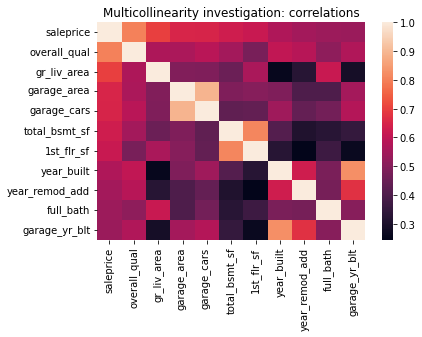

In [8]:
indexes = houses.corr()['saleprice'].sort_values(ascending = False)[0:11].index
sns.heatmap(houses.corr().loc[indexes,indexes]).set(\
            title = 'Multicollinearity investigation: correlations')
plt.savefig('../plots/multicollinearity: correlations')

Not surprisingly, there is substantial multicollinearity between the ten variables that are most correlated with saleprice.  This suggests that regularization in the modeling phase will be very important so as to remove excess features that are collinear with other features.  

For instance, year built, year remodel add, and garage year built are all related (you can't remodel before the building is built).

In [9]:
(houses.corr().loc[indexes,indexes].sum().sum()-11)/(10*11)

0.5152935744368421

Specifically, the mean correlation between any two separate features selected from this group is .52.

Saleprice correlation graph modified from: James Larkin, GA Instructor

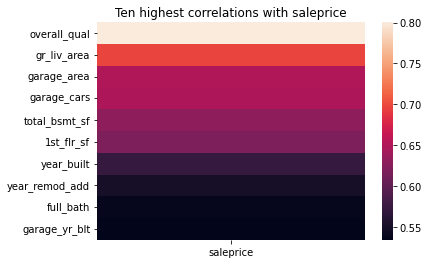

In [10]:
houses_corr = pd.DataFrame(houses.corr()['saleprice'])
houses_corr['saleprice_abs'] = houses.corr()['saleprice'].abs()
houses_corr = houses_corr.sort_values('saleprice_abs', ascending = False)[1:11]

sns.heatmap(houses_corr[['saleprice']]).set(title = 'Ten highest correlations \
with saleprice')
plt.savefig('../plots/correlations_saleprice')

From the above correlation plot, overall_qual, gr_liv_area and garage_area are the most correlated with saleprice.

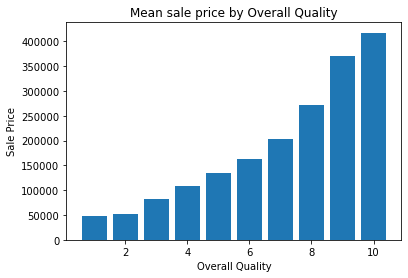

In [11]:
plt.bar(x= houses.groupby('overall_qual').mean()['saleprice'].index, \
        height = houses.groupby('overall_qual').mean()['saleprice'])
plt.title("Mean sale price by Overall Quality")
plt.xlabel("Overall Quality"); plt.ylabel('Sale Price')
plt.savefig('../plots/saleprice_overalquality')

Above we see an almost quadratic relationship between overall quality and mean sale price.  Next, lets look at the distribution of Overall Quality

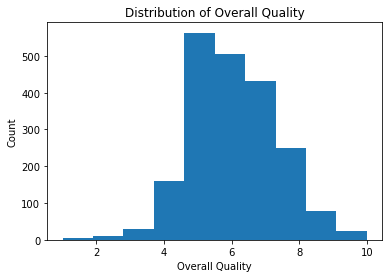

In [12]:
plt.hist(houses['overall_qual'])
plt.xlabel("Overall Quality"); plt.ylabel('Count')
plt.title('Distribution of Overall Quality')
plt.savefig('../plots/overallquality_hist')

Overall quality has far more observations above 5 than below.  It can not quite be said to have a normal distribution.  

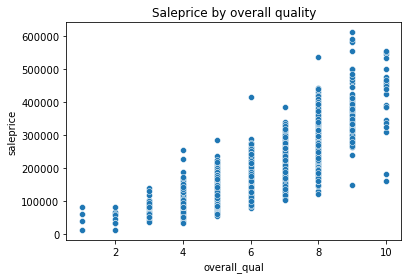

In [13]:
sns.scatterplot(data= houses, x = 'overall_qual', y = 'saleprice')\
.set(title = 'Saleprice by overall quality')
plt.savefig('../plots/sp_oq_scatter')

A scatterplot indicates a fairly neat, though broad, bound of saleprice for any given overall quality. 

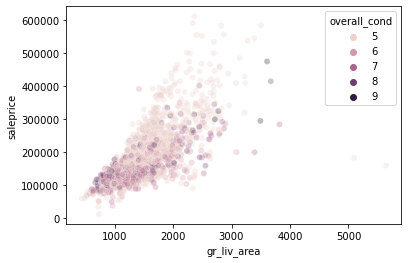

In [14]:
sns.scatterplot(data = houses.loc[houses['overall_cond']>=5,:], x = 'gr_liv_area', y = 'saleprice', \
                hue = 'overall_cond', alpha = .3)
plt.savefig('../plots/sp_gla_oc_scatter')

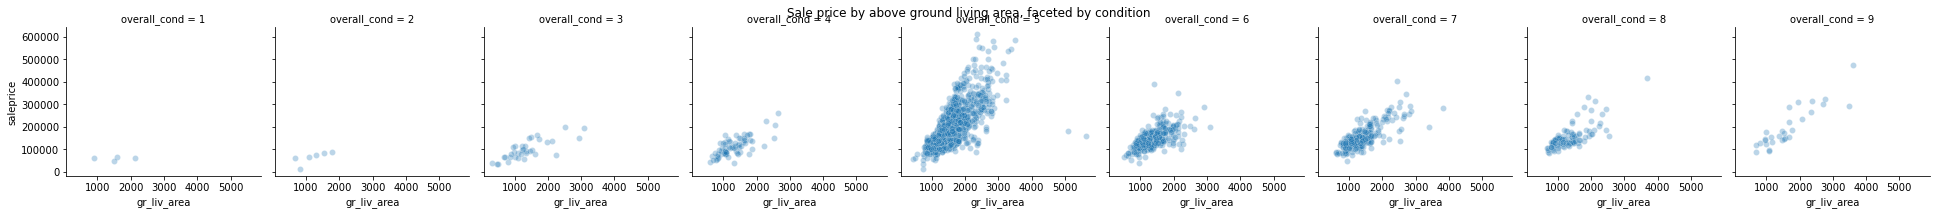

In [15]:
g = sns.FacetGrid(data=houses, col="overall_cond")

g.map(sns.scatterplot,'gr_liv_area', 'saleprice',alpha = .3).set(\
)
plt.suptitle("Sale price by above ground living area, faceted by condition")
plt.savefig('../plots/sp_gla_oc_scatter_facet')

I would have expected the houses in the best condition to have the highest price per square foot of above ground living area.  This does not appear to be the case, which leads me to believe that the impact of overall condition on saleprice is confounded by the above ground living area.  

#### missing vals

##### missing vals resources

[how to handle missing values](https://medium.com/analytics-vidhya/how-to-handle-missing-values-cbd03fb79ef8#:~:text=When%20column%20has%20more%20than,%25%20missing%20value%2C%20drop%20it.)

##### missing values analysis

In [16]:
houses.describe()

,id,pid,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod_add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_yr_blt,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,saleprice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [17]:
houses.isnull().sum().sort_values(ascending = False)[lambda x:x>0]

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_finish      114
garage_qual        114
garage_yr_blt      114
garage_cond        114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmtfin_type_1      55
bsmt_cond           55
bsmt_qual           55
mas_vnr_area        22
mas_vnr_type        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_area          1
total_bsmt_sf        1
bsmt_unf_sf          1
bsmtfin_sf_2         1
bsmtfin_sf_1         1
garage_cars          1
dtype: int64

###### Column Dropping

Variables to drop, Missing count:
Pool QC: 2042, Misc Feature: 1986, Alley: 1911, Fence: 1651

There don't seem to be many pools in Ames (9).  Likewise, only 65 houses have Miscelaneous Features (3.17%), so I believe it is reasonable to drop this feature.  Also, there are 1911 out of 2051 houses without an alley.  I'm going to remove this feature.  There are a significant number of fences (400), so I'll impute "None" for the NA values. It would be difficult to draw conclusions from columns 'Pool QC' and 'Pool Area', as there are only 9 houses with pools. 

Likewise for Misc Feature, Alley, and Fence, these do not strike me as frequent enough and/or important enough to include as a predictive feature.  I will drop all four columns.

I'll drop PID because this feature is reduntant with ID for data identification purposes.  ID I will keep for maintining identification of the data.  

In [18]:
dropped_columns = ['pid','misc_feature','misc_val','alley','pool_qc', 'pool_area']
houses.drop(columns = dropped_columns, axis = 1, inplace = True)
houses_id = houses.pop('id')

In [19]:
houses_test.drop(columns = dropped_columns, axis = 1, inplace = True)
houses_test_id = houses_test.pop('id')

I changed the 'ms_subclass' feature to categorical.

In [20]:
houses['ms_subclass'] = houses['ms_subclass'].astype('category')

In [21]:
houses.columns

Index(['ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope',
       'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod_add', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air',
       'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual',
       'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu',
       'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars',

I will also collect column names for ordinal encoding vs. One-Hot encoding.  

In [22]:
target = ['saleprice']   
 
features_ord = ['lot_shape','utilities','land_slope','overall_qual',\
'overall_cond', 'exter_qual','exter_cond', 'bsmt_qual', 'bsmt_cond', \
'bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2','heating_qc','electrical',\
'kitchen_qual', 'functional', 'fireplace_qu', 'garage_finish', 'garage_qual',
'garage_cond', 'paved_drive', 'fence']

features_nom = ['ms_subclass','ms_zoning','street','land_contour',\
'lot_config','neighborhood','condition_2','bldg_type','house_style', \
'roof_style', 'roof_matl','exterior_1st','exterior_2nd', 'mas_vnr_type',\
'foundation','heating','central_air', 'garage_type', 'misc_val', 'sale_type',]

features_cont = ['lot_frontage','lot_area','mas_vnr_area','bsmtfin_sf_1',\
'bsmtfin_sf_2','bsmt_unf_sf', 'total_bsmt_sf','1st_flr_sf', '2nd_flr_sf', \
'low_qual_fin_sf','gr_liv_area', 'garage_area', 'wood_deck_sf', 'open_porch_sf',\
'enclosed_porch','3ssn_porch', 'screen_porch', ]

features_disc = ['year_built', 'year_remod_add','bsmt_full_bath',\
'bsmt_half_bath', 'full_bath', 'half_bath','bedroom_abvgr', 'kitchen_abvgr',\
'totrms_abvgrd', 'fireplaces', 'garage_yr_blt', 'garage_cars', 'mo_sold', \
'yr_sold',]
features_type = [features_ord,features_nom,features_cont,features_disc]
features_all = features_ord + features_nom + features_cont + features_disc

Below I impute for code functionality.  See furthur below in the transformations section for comments.

In [23]:
#https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-
#pandas
#https://stackoverflow.com/questions/21271581/selecting-pandas-columns-by-dtype

houses_numeric = houses.select_dtypes(exclude=[object])
si = SimpleImputer(strategy = 'constant')

houses_numeric = pd.DataFrame(si.fit_transform(houses_numeric),\
                              columns = houses_numeric.columns)

houses_obj = houses.select_dtypes(include=[object])
si = SimpleImputer(strategy = 'constant', fill_value='None')

houses_obj_imputed = si.fit_transform(houses_obj)

houses_obj = pd.DataFrame(houses_obj_imputed, columns = houses_obj.\
                              columns)
houses_imp = houses_numeric.join(houses_obj)

houses_imp.describe()

#https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-
#pandas
#https://stackoverflow.com/questions/21271581/selecting-pandas-columns-by-dtype


,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod_add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_yr_blt,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,mo_sold,yr_sold,saleprice
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,57.008776,57.944417,10065.208191,6.112140,5.562165,1971.708922,1984.190151,98.626524,442.084837,47.935641,567.451487,1057.471965,1164.488055,329.329108,5.512921,1499.330083,0.427109,0.063384,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1868.725987,1.775719,473.440761,93.833740,47.556802,22.571916,2.591419,16.511458,6.219893,2007.775719,181469.701609
std,42.824223,33.137332,6742.488909,1.426271,1.104497,30.177889,21.036250,174.324690,461.195041,164.964052,445.022846,449.908003,396.446923,425.671046,51.068870,500.447829,0.522589,0.251590,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,454.133654,0.765357,216.135102,128.549416,66.747241,59.845110,25.229615,57.374204,2.744736,1.312014,79258.659352
min,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,20.000000,43.500000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,50.000000,63.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.000000,994.000000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,70.000000,78.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,159.000000,733.500000,0.000000,811.000000,1318.500000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,12.000000,2010.000000,611657.000000


In [24]:
def ft_price_sd(df,features,target):
    target_sd_by_feature =  {feat:np.std(df.groupby([feat])[target].mean().values)\
            for feat in features}
    return pd.DataFrame.from_dict(target_sd_by_feature, orient='index', columns\
            = ['target_sd']).sort_values(by = 'target_sd', ascending = False)

cat_price_sd = ft_price_sd(houses_imp, houses_obj.columns, 'saleprice')
cat_price_sd

,target_sd
condition_2,112416.338996
exter_qual,107679.802091
kitchen_qual,89597.529503
bsmt_qual,83220.946312
garage_qual,72754.521542
exter_cond,66754.802867
fireplace_qu,66203.400248
neighborhood,65776.772939
ms_zoning,61551.176103
roof_matl,61035.047243


In [25]:
def gini(class_probs):
    return sum([p*(1-p) for p in class_probs])

In [26]:
def ft_gini(df,features): 
    feat_gini = {feat:gini(df[feat].value_counts(normalize= True)) for feat in features}
    return pd.DataFrame.from_dict(feat_gini, orient='index', columns\
            = ['gini']).sort_values(by = 'gini', ascending = False)

ft_gini_categoricals = ft_gini(houses_imp, houses_obj.columns)


In [27]:
ft_cat_gini_sd = ft_gini_categoricals.join(cat_price_sd)
ft_cat_gini_sd['sd_x_gini'] = ft_cat_gini_sd['gini']*ft_cat_gini_sd['target_sd']
ft_cat_gini_sd = ft_cat_gini_sd.sort_values(by = 'sd_x_gini', ascending = False)
ft_cat_gini_sd[0:8]

,gini,target_sd,sd_x_gini
neighborhood,0.933349,65776.772939,61392.703436
exter_qual,0.513133,107679.802091,55254.065238
bsmt_qual,0.625886,83220.946312,52086.851446
kitchen_qual,0.579029,89597.529503,51879.611139
exterior_1st,0.800534,55488.071230,44420.072775
fireplace_qu,0.656592,66203.400248,43468.614102
garage_finish,0.684277,52429.106128,35876.052486
exterior_2nd,0.805382,40197.108039,32374.039435


Above we see a table showing the gini index, the standard deviation of the the sale price according to category, and finally the multiple of the two values to arrive at the features with the most variation in sale price, adjusted for the gini (an information metric indicating the iner-class dispersion for a feature).  These features may be the most useful for investigations of potential feature engineering.  exterior_qual, exterior_1st appear to potentially benefit from feature engineering. 

In [28]:
houses['exterior_1st']

0       HdBoard
1       VinylSd
2       VinylSd
3       VinylSd
4       Wd Sdng
         ...   
2046    VinylSd
2047    VinylSd
2048    BrkFace
2049    Plywood
2050    VinylSd
Name: exterior_1st, Length: 2051, dtype: object

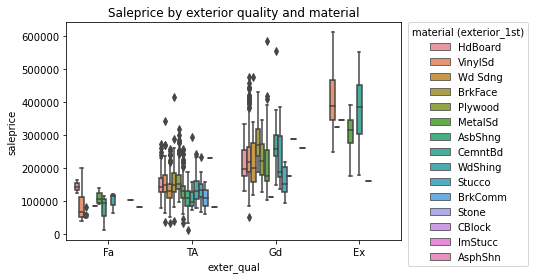

In [29]:
# g = sns.FacetGrid(houses, col = 'exter_qual')
# g.map(sns.boxplot, 'exter_1st' ,'saleprice')
sns.boxplot(data = houses, x = 'exter_qual', y='saleprice', hue = 'exterior_1st'\
           ,order = ['Fa', 'TA', 'Gd', 'Ex'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title = 'material (exterior_1st)')
plt.title('Saleprice by exterior quality and material')
plt.savefig('../plots/sp_eq_material',bbox_inches = 'tight')

From the above graph it is apparent that there is significant variation in the mean sale price for the various exterior materials for given quality levels.  The exterior quality appears to explain more of the variance in the saleprice, but the material also appears to have some explanatory power.  The influence of the material appears to be different for each quality, so I will create a feature that is their combination. 

In [30]:
houses['ext_qual_1st'] = houses['exter_qual']+houses['exterior_1st']
houses_test['ext_qual_1st'] = houses_test['exter_qual']+houses_test['exterior_1st']


```To-do:``` Make 'month_sold' a nominal variable.

For columns that have NA values, the data dictionary indicates that the feature does not exist for the observation, as opposed to indicating that there was not any record.  The columns with na values that indicate the feature is not present for a given observation include:

Fence, FireplaceQu (and 'Fireplaces' ?), 

Garage Cond, Garage Qual, ('Garage Area' ?), Garage Cars, Garage Finish, Garage Yr Blt, Garage Type
Note: there is one fewer Garage Type NAs than there are NA's for the other garage features.  I need to investigate further.

Bsmt features are also asymetrically missing values, which needs to be investigated.  

Mas Vnr does not rely on NA's but instead has 'None' as a value to indicate if a feature is missing.  Imputing with the mode may be the best option here.



There are a significant number of fireplaces and Na values for Fireplace Qu indicate no fireplace, so I will replace the missing values with ```'None'``` .

Only 65 houses with misc features.  Shed is the most common of these with 56, but the median sale price is not much different (163,000.0 with no shed vs 153,750.0 with a shed)

I believe that in accordance with the format for other columns, the missing values for lot frontage likely indicate that the lot has no frontage.  This assumption is supported by the observation that the minimum recorded frontage is greater than zero. I will impute zeros in place of the NAs.

In [31]:
houses.isna().sum().value_counts()

0       52
1        6
114      4
55       3
22       2
2        2
330      1
58       1
56       1
1000     1
113      1
1651     1
dtype: int64

In [32]:
houses.dtypes

ms_subclass     category
ms_zoning         object
lot_frontage     float64
lot_area           int64
street            object
                  ...   
mo_sold            int64
yr_sold            int64
sale_type         object
saleprice          int64
ext_qual_1st      object
Length: 75, dtype: object

In [33]:
#https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-
#pandas
#https://stackoverflow.com/questions/21271581/selecting-pandas-columns-by-dtype

houses_numeric = houses.select_dtypes(exclude=[object])
si = SimpleImputer(strategy = 'constant')

houses_numeric = pd.DataFrame(si.fit_transform(houses_numeric),\
                              columns = houses_numeric.columns)

houses_obj = houses.select_dtypes(include=[object])
si = SimpleImputer(strategy = 'constant', fill_value='None')

houses_obj_imputed = si.fit_transform(houses_obj)

houses_obj = pd.DataFrame(houses_obj_imputed, columns = houses_obj.\
                              columns)
houses_imp = houses_numeric.join(houses_obj)

houses_imp.describe()

#https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-
#pandas
#https://stackoverflow.com/questions/21271581/selecting-pandas-columns-by-dtype


,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod_add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_yr_blt,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,mo_sold,yr_sold,saleprice
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,57.008776,57.944417,10065.208191,6.112140,5.562165,1971.708922,1984.190151,98.626524,442.084837,47.935641,567.451487,1057.471965,1164.488055,329.329108,5.512921,1499.330083,0.427109,0.063384,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1868.725987,1.775719,473.440761,93.833740,47.556802,22.571916,2.591419,16.511458,6.219893,2007.775719,181469.701609
std,42.824223,33.137332,6742.488909,1.426271,1.104497,30.177889,21.036250,174.324690,461.195041,164.964052,445.022846,449.908003,396.446923,425.671046,51.068870,500.447829,0.522589,0.251590,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,454.133654,0.765357,216.135102,128.549416,66.747241,59.845110,25.229615,57.374204,2.744736,1.312014,79258.659352
min,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,20.000000,43.500000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,50.000000,63.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.000000,994.000000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,70.000000,78.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,159.000000,733.500000,0.000000,811.000000,1318.500000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,12.000000,2010.000000,611657.000000


In [34]:
# imputing test data
houses_test_numeric = houses_test.select_dtypes(exclude=[object])
si = SimpleImputer(strategy = 'constant')
si.fit(houses_test_numeric)
houses_test_numeric_imputed = si.transform(houses_test_numeric)
houses_test_numeric = pd.DataFrame(houses_test_numeric_imputed, columns = houses_test_numeric.\
                              columns)

houses_test_obj = houses_test.select_dtypes(include=[object])
si = SimpleImputer(strategy = 'constant', fill_value='None')

si.fit(houses_test_obj)
houses_test_obj_imputed = si.transform(houses_test_obj)
houses_test_obj = pd.DataFrame(houses_test_obj_imputed, columns = houses_test_obj.\
                              columns)
houses_test_imp = houses_test_numeric.join(houses_test_obj)

houses_test_imp.describe()

,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod_add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_yr_blt,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,mo_sold,yr_sold
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,58.268793,56.872437,10307.033030,6.050114,5.566059,1970.492027,1984.417995,106.115034,441.328018,53.896355,539.133257,1034.357631,1145.787016,348.398633,2.728929,1496.914579,0.439636,0.055809,1.539863,0.398633,2.879271,1.047836,6.454442,0.618451,1875.445330,1.742597,470.362187,93.430524,47.070615,24.064920,2.597950,14.830296,6.202733,2007.825740
std,42.235407,34.269502,10002.674602,1.369065,1.128903,30.395895,20.450725,187.086530,438.457329,178.632355,426.172161,413.446291,375.264111,432.985566,32.572548,506.468967,0.529948,0.229683,0.559060,0.505927,0.830712,0.223966,1.596632,0.669571,436.866917,0.750391,212.734075,121.181702,68.180939,73.249463,24.962482,53.003794,2.642498,1.327861
min,20.000000,0.000000,1477.000000,2.000000,1.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,40.000000,7297.250000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,216.000000,789.000000,864.000000,0.000000,0.000000,1114.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,322.500000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,60.000000,9446.000000,6.000000,5.000000,1972.000000,1992.000000,0.000000,373.000000,0.000000,452.000000,975.000000,1063.000000,0.000000,0.000000,1436.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1976.500000,2.000000,473.000000,0.000000,27.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,78.000000,11589.000000,7.000000,6.000000,1999.750000,2003.000000,171.750000,734.750000,0.000000,780.000000,1247.000000,1358.000000,720.000000,0.000000,1779.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2000.000000,2.000000,576.000000,170.750000,69.750000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,182.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,2288.000000,1526.000000,2046.000000,2630.000000,2674.000000,2065.000000,481.000000,4476.000000,2.000000,1.000000,4.000000,2.000000,6.000000,3.000000,12.000000,3.000000,2010.000000,4.000000,1488.000000,690.000000,742.000000,1012.000000,360.000000,576.000000,12.000000,2010.000000


In [35]:
def zero_counts(dataframe):
    zero_counts_dict = {col:dataframe.loc[dataframe[col]==0,col].count() \
               for col in dataframe.columns}
    zero_counts_df = pd.DataFrame.from_dict(data = zero_counts_dict, \
                                            orient = 'index',\
                                            columns = ['zero_counts'])
    zero_counts_df_sorted = zero_counts_df.sort_values(by = 'zero_counts', \
                                                       ascending = False)
    return zero_counts_df_sorted.loc[zero_counts_df_sorted['zero_counts']>0,:]

zero_counts(houses_imp)

,zero_counts
3ssn_porch,2025
low_qual_fin_sf,2018
bsmt_half_bath,1925
screen_porch,1870
bsmtfin_sf_2,1804
enclosed_porch,1724
half_bath,1308
mas_vnr_area,1238
bsmt_full_bath,1202
2nd_flr_sf,1191


In [36]:
# https://stackoverflow.com/questions/1007481/how-to-replace-whitespaces-with-\
# underscore
# https://www.geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/

# rename_dict = dict(map(lambda i,j : (i,j) , houses_imp.columns,[col.replace(' ','_') for col in houses_imp.columns]))

# houses_imp.columns

In [37]:
import numpy as np

In [38]:
def ft_price_sd(df,features,target):
    target_sd_by_feature =  {feat:np.std(df.groupby([feat])[target].mean().values)\
            for feat in features}
    return pd.DataFrame.from_dict(target_sd_by_feature, orient='index', columns\
            = ['target_sd']).sort_values(by = 'target_sd', ascending = False)

cat_price_sd = ft_price_sd(houses_imp, houses_obj.columns, 'saleprice')


In [39]:
# cat_price_sd

[plotting ref1](https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot)
[plotting ref2](https://www.reddit.com/r/learnpython/comments/3cjnpg/seaborn_xaxis_as_index/)

[Text(0, 0.5, 'Categorical Feature'), Text(0.5, 0, 'Price Standard Deviation')]

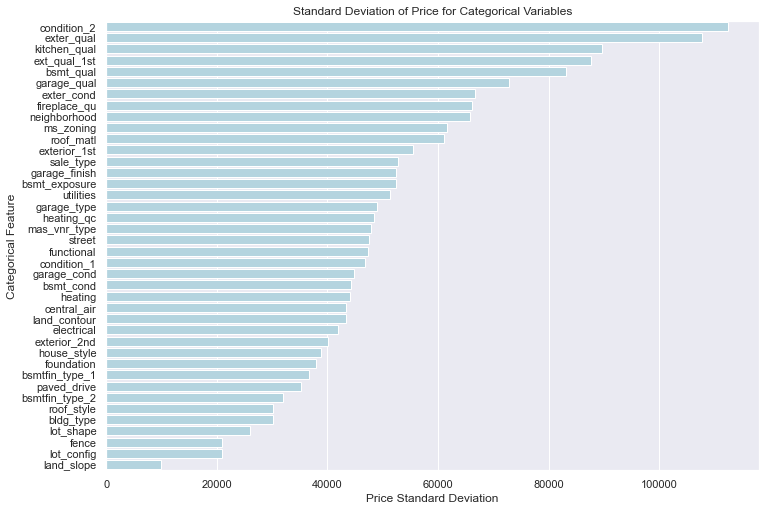

In [40]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

p1 = sns.barplot(data = cat_price_sd.reset_index(), x = 'target_sd', y = 'index', \
            color = 'lightblue')
p1.set(title = 'Standard Deviation of Price for Categorical Variables')
p1.set(ylabel = 'Categorical Feature', xlabel = 'Price Standard Deviation')


[savefig](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html)

In [41]:
picture1 = p1.get_figure()
plt.savefig('sd_feat')

<Figure size 842.4x595.44 with 0 Axes>

Norm      2025
Feedr       11
Artery       5
PosA         3
PosN         3
RRNn         2
RRAe         1
RRAn         1
Name: condition_2, dtype: int64

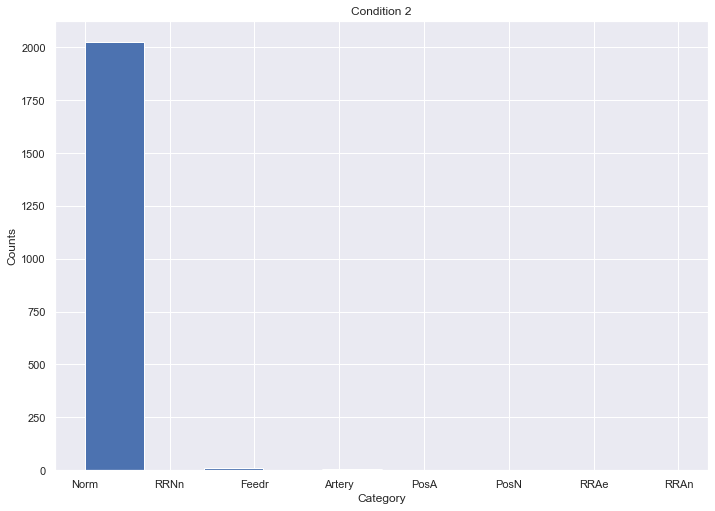

In [42]:
houses_imp.groupby('condition_2').mean()['saleprice']

houses_imp['condition_2'].hist().set(title='Condition 2', xlabel='Category', \
                                     ylabel = 'Counts',)
houses_imp['condition_2'].value_counts()

Condition 2 (Nominal): Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	

In [43]:
X = houses_imp.drop(columns = ['saleprice'])
y = houses_imp['saleprice']

In [44]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = .25,
    random_state = 3
)

In [45]:
ohe = OneHotEncoder(
    drop = 'first',
    handle_unknown = 'ignore',
    sparse = False
)

In [46]:
ctx = ColumnTransformer(
    transformers = [
        #('alias_first', actual_transformer, list_of_cols_to_apply_to)
        ('one_hot', ohe,\
         houses.select_dtypes(include = ['object']).columns)
    ], remainder = 'passthrough', #don't drop the others
    verbose_feature_names_out = False
)

In [47]:
#transform train
ctx.fit(X_train)
X_train_enc = ctx.transform(X_train)

#transform test
X_val_enc = ctx.transform(X_val)

#recreate dataframes
X_train_enc = pd.DataFrame(X_train_enc, columns = ctx.get_feature_names_out())
X_val_enc = pd.DataFrame(X_val_enc, columns = ctx.get_feature_names_out())

X_train_enc.shape, X_val_enc.shape


/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4, 7, 9, 13, 20, 39] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


((1538, 279), (513, 279))

In [48]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train_enc,)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())
Xs_val = pd.DataFrame(ss.transform(X_val_enc), columns = ss.get_feature_names_out())

### Modeling

The baseline model is given by an estimation of any house sale with the average sale price of previously seen house sales.

This baseline model will provide a standard for further modeling efforts.

The two statistics that will be used are RMSE, or root mean squared error, which represents the typical error in the prediction, and the R-squared statistic, which indicates the proportion of the variance in the target variable that is explained by the model.

In [49]:
pred_b = y_train.mean()

round((sum((y_val - pred_b).pow(2))/len(y_val))**.5,2), \
mean_squared_error(y_val, [pred_b]*len(y_val), squared = False).round(2)

(79420.42, 79420.42)

Above is the RMSE of the baseline model as shown by a self-made implementation as well as the sci-kit learn implementation.

In [50]:
r2_score(y_val, [pred_b]*len(y_val)).round(2)

-0.0

Above is the r2 score.  It is practically zero, which is to be expected for a baseline model and it indicates that no variance is explained by the model.

In [51]:
lr = LinearRegression()
lr.fit(Xs_train, y_train)
lr.score(Xs_train, y_train), lr.score(Xs_val, y_val)

(0.9479833244815522, -4.80892048140335e+24)

The baseline linear regression model substantially overfits the data, as seen by
the R-squared statistic, which represents the proportion of the variance
in sale price that is explained by the model.

In [52]:
linear_preds = lr.predict(Xs_val)

mean_squared_error(y_train,lr.predict(Xs_train), squared = False),\
mean_squared_error(y_val, linear_preds, squared = False),

(18059.122836018683, 1.740855557157454e+17)

Above we see that the RMSE also indicatees overfitting.

In [53]:
alphas = np.arange(.01,15,.1)
rcv = RidgeCV(alphas = alphas)
rcv.fit(Xs_train, y_train)
print(f'R-squared:{rcv.score(Xs_train, y_train), rcv.score(Xs_val, y_val)} RMSE: {mean_squared_error(y_train,rcv.predict(Xs_train), squared = False), mean_squared_error(y_val,rcv.predict(Xs_val), squared = False)}')


R-squared:(0.9469176315601981, 0.8183544398898858) RMSE: (18243.178267619143, 33833.843319507694)


Again we see evidence of overfitting demonstrated here by the R-squared and RMSE scores.
Lasso may lead to less overfitting and allow for better feature selection as well.

[RMSE formula](https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python)

In [54]:
lcv = LassoCV(alphas = np.arange(.001, 1000, 10))
lcv.fit(Xs_train, y_train)
lcv.score(Xs_train, y_train), lcv.score(Xs_val, y_val)

/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1713782007.8555298, tolerance: 769377038.104955
  model = cd_fast.enet_coordinate_descent_gram(
/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4301447438.389404, tolerance: 769377038.104955
  model = cd_fast.enet_coordinate_descent_gram(
/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183901969892.47885, tolerance: 769377038.104955
  model = cd_fast.enet_coordinate_descent_gram(
/Users/william/opt/anaconda3/lib/python3.9/site-packa

(0.940005422722543, 0.8356260232807922)

In [55]:
lcv.score(Xs_train, y_train), lcv.score(Xs_val, y_val)

(0.940005422722543, 0.8356260232807922)

In [56]:
mean_squared_error(y_train,rcv.predict(Xs_train), squared = False), mean_squared_error(y_val,rcv.predict(Xs_val), squared = False)

(18243.178267619143, 33833.843319507694)

Unfortunately, there little difference between the lasso and ridge in terms of the r2 score and the rmse.  

In [57]:
lr = LinearRegression()
lr.fit(Xs_train, y_train)
lr.score(Xs_train, y_train), lr.score(Xs_val, y_val)

(0.9479833244815522, -4.80892048140335e+24)

In [58]:
mean_squared_error(y_val,lr.predict(Xs_val), squared = False)

1.740855557157454e+17

In [59]:
en = ElasticNetCV(l1_ratio=np.arange(.01,1,.01))


In [60]:
en.fit(Xs_train, y_train)
en.score(Xs_val,y_val)
best_alpha, best_l1_ratio = en.alpha_, en.l1_ratio_

In [61]:
best_alpha, best_l1_ratio, en.score(Xs_val,y_val), en.score(Xs_train,y_train)

(64.43575137533763, 0.99, 0.8535596484289389, 0.9159774775753706)

After adjusting the l1_ratio for ElasticNet, the best l1 ratio approaches 1 indicating that the lasso is the best model.  However, the elasticnet implementation is generating a better score than seen previously with the lasso, so I will proceed with the elastic net for examination of the coefficients.

The high l1_ratio indicates that removing features entirely leads to the most generalizable results and the least overfitting.

The high l1_ration means that the sum of the absolute value of the coefficients factors into the loss function of the model as the regularization term, which is the Mean Squared error plus the regularization term.


To interpret the coefficients, one must keep in mind that they indicate the change in saleprice per change of one standard deviation of the predictor variable.

In [62]:
en.score(Xs_train, y_train), en.score(Xs_val, y_val)

(0.9159774775753706, 0.8535596484289389)

In [63]:
best_alpha 

64.43575137533763

In [64]:
en.fit(pd.concat([Xs_train,Xs_val]),pd.concat([y_train,y_val]))
en.alpha_

64.00919998274404

In [65]:
en.alpha_, en.l1_ratio_

(64.00919998274404, 0.99)

In [66]:
{feature: coef for coef, feature in zip(en.coef_,en.feature_names_in_)}

{'ms_zoning_C (all)': -793.0309604223222,
 'ms_zoning_FV': 671.3905855931878,
 'ms_zoning_RH': 127.2215951024555,
 'ms_zoning_RL': 716.6856234508699,
 'ms_zoning_RM': -1122.1952122988323,
 'street_Pave': 197.3676260511445,
 'lot_shape_IR2': 629.8425525163077,
 'lot_shape_IR3': -1008.3518927773067,
 'lot_shape_Reg': -946.9604079712296,
 'land_contour_HLS': 2062.409819236089,
 'land_contour_Low': 102.53219444676124,
 'land_contour_Lvl': 0.0,
 'utilities_NoSeWa': -568.5673982836365,
 'lot_config_CulDSac': 1408.8245437147418,
 'lot_config_FR2': -559.7309715632964,
 'lot_config_FR3': -202.92786219432375,
 'lot_config_Inside': -107.3832843188997,
 'land_slope_Mod': 643.5539994116916,
 'land_slope_Sev': -243.0237766090823,
 'neighborhood_Blueste': -98.90667363463582,
 'neighborhood_BrDale': -63.66645271788003,
 'neighborhood_BrkSide': 87.66882763559899,
 'neighborhood_ClearCr': 56.22603871284048,
 'neighborhood_CollgCr': -892.4806009972036,
 'neighborhood_Crawfor': 1221.3489881574792,
 'neigh

In [67]:
exterior_coefs = pd.DataFrame.from_dict({feature: [coef,abs(coef)] for coef, feature in \
                        zip(en.coef_,en.feature_names_in_) if \
                        'ext_qual_1st' in feature}, orient = 'index', \
                       columns = ['coef', 'abs_coef']).sort_values(by = 'abs_coef', ascending = False)

In [68]:
exterior_coefs

,coef,abs_coef
ext_qual_1st_ExVinylSd,6039.608281,6039.608281
ext_qual_1st_ExStucco,-5087.875123,5087.875123
ext_qual_1st_ExCemntBd,2158.264702,2158.264702
ext_qual_1st_GdBrkFace,1527.919425,1527.919425
ext_qual_1st_ExMetalSd,1039.066457,1039.066457
ext_qual_1st_TAVinylSd,-977.318521,977.318521
ext_qual_1st_GdMetalSd,882.613644,882.613644
ext_qual_1st_TACemntBd,-847.865225,847.865225
ext_qual_1st_GdHdBoard,-833.864810,833.864810
ext_qual_1st_TAWd Sdng,-797.826800,797.826800


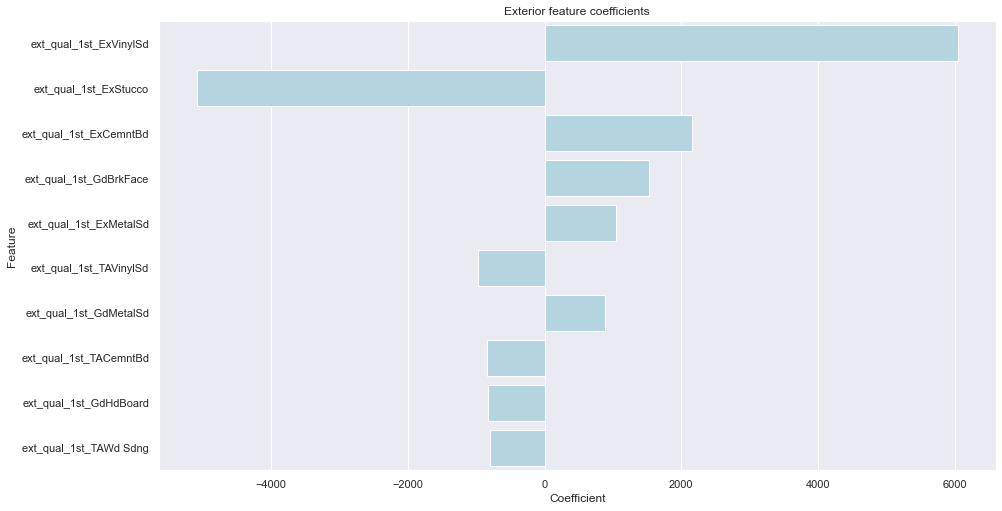

In [69]:
sns.set(rc={'figure.figsize':(15,8.27)})

p1 = sns.barplot(data = exterior_coefs.reset_index()[0:10], x = 'coef', y = 'index', \
            color = 'lightblue')
p1.set(title = 'Exterior feature coefficients')
p1.set(ylabel = 'Feature', xlabel = 'Coefficient')
plt.savefig('../plots/Ext_ft_coefs')

From the above analysis, we can see that the coefficients with the largest magnitude correspond to ext_qual_1st_ExVinylSd

Below is the fitting on the entire dataset and the generation of a submission to be sent to Kaggle.

In [70]:
houses_test_imp['ext_qual_1st']

0      TAAsbShng
1      TAPlywood
2      GdVinylSd
3      GdWd Sdng
4      TAPlywood
         ...    
873    TAHdBoard
874    GdVinylSd
875    TAHdBoard
876    TAHdBoard
877    TAMetalSd
Name: ext_qual_1st, Length: 878, dtype: object

In [71]:
houses_test_imp_enc = ctx.transform(houses_test_imp)
houses_test_imp_enc_ss = pd.DataFrame(ss.transform(houses_test_imp_enc), columns = ss.get_feature_names_out())

/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4, 13, 14, 15, 16, 20, 25, 28, 29, 38, 39] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [72]:
en.alpha_

en_preds2 = en.predict(houses_test_imp_enc_ss)

en_preds2 = pd.DataFrame(en_preds2,columns = ['SalePrice'])

en_preds2.insert(loc = 0, column= 'Id', value = houses_test_id)
  
en_preds2.to_csv(f'./en_{time.time()}_simple.csv', index = False)

### Conclusions

Based on the preceding analysis, which identified that exterior quality and exterior materials are important contributors to the eventual sale price of a home, we can conclude specifically that for homes with high exterior  vinyl siding is ideal, while stucco should be avoided.  

The initial analysis demostrated clear associations between exterior quality and exterior material.  Subsequently, the modelling process revealed the specific combinations of exterior quality and exterior material that had the strongest association with sale price while holding all other features constant.

This finding can benefit housing development in Ames, Iowa when developers are considering what material to use on new houses with presumably excellent quality exteriors.

To further strengthen the present analysis, next steps will include: witholding binary features from the standard scaling process, transforming the response prior to modeling for more robust conclusions, and exploring additional features and interactions that could be useful in panning.